In [1]:
# Import required packages
import gymnasium as gym
from tqdm.notebook import tqdm
import numpy as np
import mani_skill.envs
import matplotlib.pyplot as plt

In [2]:
import torch

env_id = "PickCube-v1" 
obs_mode = "voxel" 
obs_mode_config = {"coord_bounds": [-13, -10, -1, 1, 10, 1], "voxel_size": 50, 
                   "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                   "segmentation": True}
control_mode = "pd_joint_delta_pos"
reward_mode = "dense"
robot_uids = "panda"
# create an environment with our configs and then reset to a clean state
env = gym.make(env_id,
               num_envs=2,
               obs_mode=obs_mode,
               reward_mode=reward_mode,
               control_mode=control_mode,
               robot_uids=robot_uids,
               obs_mode_config=obs_mode_config,
               enable_shadow=True # this makes the default lighting cast shadows
               )
obs, _ = env.reset()


MESA-INTEL: warning: Performance support disabled, consider sysctl dev.i915.perf_stream_paranoid=0

MESA-INTEL: warning: Performance support disabled, consider sysctl dev.i915.perf_stream_paranoid=0

/home/nan/Desktop/ManiSkill/mani_skill/envs/utils/observations/voxelizer.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._coord_bounds = torch.tensor(coord_bounds, dtype=torch.float,


/home/nan/.virtualenvs/mstest/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_rgb_array to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_rgb_array` for environment variables or `env.get_wrapper_attr('render_rgb_array')` that will search the reminding wrappers.
  logger.warn(


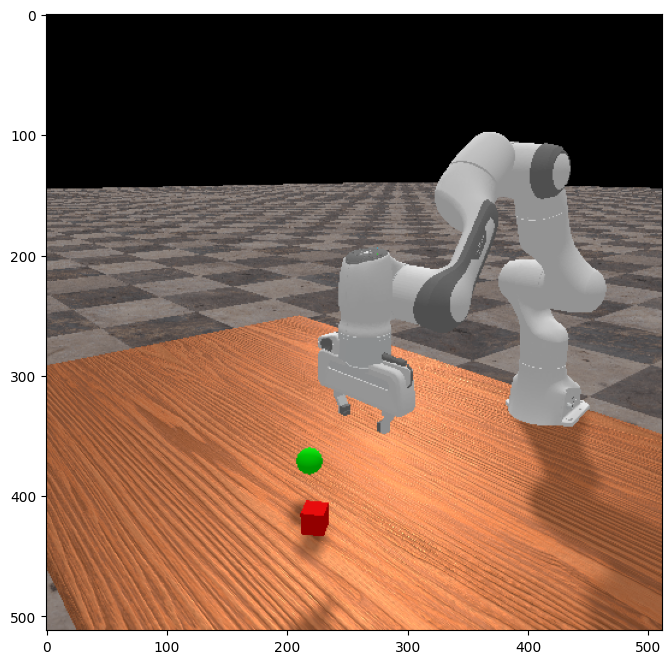

In [3]:
# take a look at the current state of the 4 parallel environments we created
fig, axs = plt.subplots(1, figsize=(8, 8))
rgbs = env.render_rgb_array() # this is a easy way to get the rgb array without having to set render_mode
plt.imshow(rgbs[0].cpu().numpy())


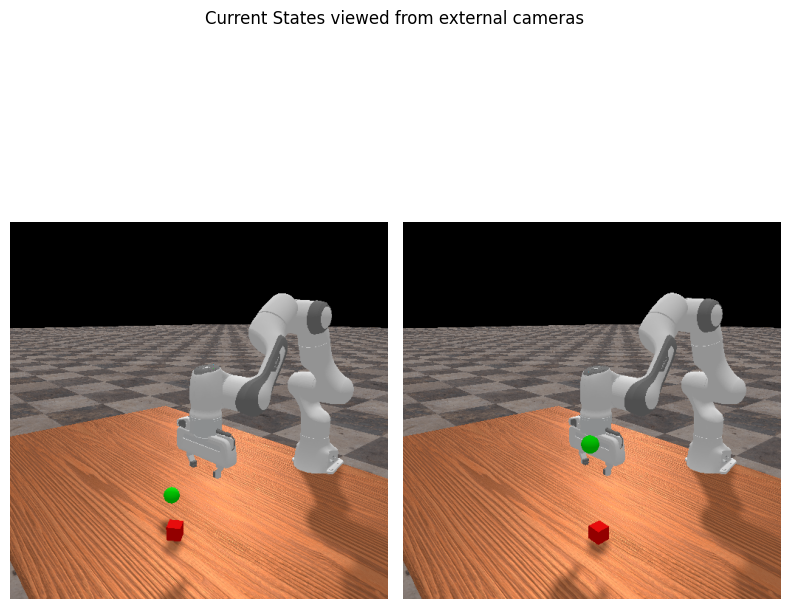

In [5]:
# visualizing RGBs for multiple envs
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
rgbs = env.render_rgb_array() # this is a easy way to get the rgb array without having to set render_mode
for i, ax in enumerate(axs.flatten()):
    ax.imshow(rgbs[i].cpu().numpy())
    ax.axis("off")
plt.suptitle("Current States viewed from external cameras")
fig.tight_layout()
env.close()

In [6]:
# Borrowed from https://github.com/stepjam/ARM/blob/main/arm/utils.py

import numpy as np
import pyrender
import torch
import trimesh
from pyrender.trackball import Trackball
# from rlbench.backend.const import DEPTH_SCALE
from scipy.spatial.transform import Rotation

# SCALE_FACTOR = DEPTH_SCALE
DEFAULT_SCENE_SCALE = 2.0


def loss_weights(replay_sample, beta=1.0):
    loss_weights = 1.0
    if 'sampling_probabilities' in replay_sample:
        probs = replay_sample['sampling_probabilities']
        loss_weights = 1.0 / torch.sqrt(probs + 1e-10)
        loss_weights = (loss_weights / torch.max(loss_weights)) ** beta
    return loss_weights


def soft_updates(net, target_net, tau):
    for param, target_param in zip(net.parameters(), target_net.parameters()):
        target_param.data.copy_(
            tau * param.data + (1 - tau) * target_param.data
        )


def stack_on_channel(x):
    # expect (B, T, C, ...)
    return torch.cat(torch.split(x, 1, dim=1), dim=2).squeeze(1)


def normalize_quaternion(quat):
    return np.array(quat) / np.linalg.norm(quat, axis=-1, keepdims=True)


def quaternion_to_discrete_euler(quaternion, resolution):
    euler = Rotation.from_quat(quaternion).as_euler('xyz', degrees=True) + 180
    assert np.min(euler) >= 0 and np.max(euler) <= 360
    disc = np.around((euler / resolution)).astype(int)
    disc[disc == int(360 / resolution)] = 0
    return disc


def discrete_euler_to_quaternion(discrete_euler, resolution):
    euluer = (discrete_euler * resolution) - 180
    return Rotation.from_euler('xyz', euluer, degrees=True).as_quat()


def point_to_voxel_index(
        point: np.ndarray,
        voxel_size: np.ndarray,
        coord_bounds: np.ndarray):
    bb_mins = np.array(coord_bounds[0:3])
    bb_maxs = np.array(coord_bounds[3:])
    dims_m_one = np.array([voxel_size] * 3) - 1
    bb_ranges = bb_maxs - bb_mins
    res = bb_ranges / (np.array([voxel_size] * 3) + 1e-12)
    voxel_indicy = np.minimum(
        np.floor((point - bb_mins) / (res + 1e-12)).astype(
            np.int32), dims_m_one)
    return voxel_indicy


def point_to_pixel_index(
        point: np.ndarray,
        extrinsics: np.ndarray,
        intrinsics: np.ndarray):
    point = np.array([point[0], point[1], point[2], 1])
    world_to_cam = np.linalg.inv(extrinsics)
    point_in_cam_frame = world_to_cam.dot(point)
    px, py, pz = point_in_cam_frame[:3]
    px = 2 * intrinsics[0, 2] - int(-intrinsics[0, 0] * (px / pz) + intrinsics[0, 2])
    py = 2 * intrinsics[1, 2] - int(-intrinsics[1, 1] * (py / pz) + intrinsics[1, 2])
    return px, py


def _compute_initial_camera_pose(scene):
    # Adapted from:
    # https://github.com/mmatl/pyrender/blob/master/pyrender/viewer.py#L1032
    centroid = scene.centroid
    scale = scene.scale
    if scale == 0.0:
        scale = DEFAULT_SCENE_SCALE
    s2 = 1.0 / np.sqrt(2.0)
    cp = np.eye(4)
    cp[:3, :3] = np.array([[0.0, -s2, s2], [1.0, 0.0, 0.0], [0.0, s2, s2]])
    hfov = np.pi / 6.0
    dist = scale / (2.0 * np.tan(hfov))
    cp[:3, 3] = dist * np.array([1.0, 0.0, 1.0]) + centroid
    return cp


def _from_trimesh_scene(
        trimesh_scene, bg_color=None, ambient_light=None):
    # convert trimesh geometries to pyrender geometries
    geometries = {name: pyrender.Mesh.from_trimesh(geom, smooth=False)
                  for name, geom in trimesh_scene.geometry.items()}
    # create the pyrender scene object
    scene_pr = pyrender.Scene(bg_color=bg_color, ambient_light=ambient_light)
    # add every node with geometry to the pyrender scene
    for node in trimesh_scene.graph.nodes_geometry:
        pose, geom_name = trimesh_scene.graph[node]
        scene_pr.add(geometries[geom_name], pose=pose)
    return scene_pr


def _create_bounding_box(scene, voxel_size, res):
    l = voxel_size * res
    T = np.eye(4)
    w = 0.01
    for trans in [[0, 0, l / 2], [0, l, l / 2], [l, l, l / 2], [l, 0, l / 2]]:
        T[:3, 3] = np.array(trans) - voxel_size / 2
        scene.add_geometry(trimesh.creation.box(
            [w, w, l], T, face_colors=[0, 0, 0, 255]))
    for trans in [[l / 2, 0, 0], [l / 2, 0, l], [l / 2, l, 0], [l / 2, l, l]]:
        T[:3, 3] = np.array(trans) - voxel_size / 2
        scene.add_geometry(trimesh.creation.box(
            [l, w, w], T, face_colors=[0, 0, 0, 255]))
    for trans in [[0, l / 2, 0], [0, l / 2, l], [l, l / 2, 0], [l, l / 2, l]]:
        T[:3, 3] = np.array(trans) - voxel_size / 2
        scene.add_geometry(trimesh.creation.box(
            [w, l, w], T, face_colors=[0, 0, 0, 255]))


def create_voxel_scene(
        voxel_grid: np.ndarray,
        q_attention: np.ndarray = None,
        highlight_coordinate: np.ndarray = None,
        highlight_alpha: float = 1.0,
        voxel_size: float = 0.1,
        show_bb: bool = False,
        alpha: float = 0.5):
    _, d, h, w = voxel_grid.shape
    v = voxel_grid.transpose((1, 2, 3, 0))
    occupancy = v[:, :, :, -1] != 0
    alpha = np.expand_dims(np.full_like(occupancy, alpha, dtype=np.float32), -1)
    rgb = np.concatenate([(v[:, :, :, 3:6] + 1)/ 2.0, alpha], axis=-1)

    if q_attention is not None:
        q = np.max(q_attention, 0)
        q = q / np.max(q)
        show_q = (q > 0.75)
        occupancy = (show_q + occupancy).astype(bool)
        q = np.expand_dims(q - 0.5, -1)  # Max q can be is 0.9
        q_rgb = np.concatenate([
            q, np.zeros_like(q), np.zeros_like(q),
            np.clip(q, 0, 1)], axis=-1)
        rgb = np.where(np.expand_dims(show_q, -1), q_rgb, rgb)

    if highlight_coordinate is not None:
        x, y, z = highlight_coordinate
        occupancy[x, y, z] = True
        rgb[x, y, z] = [1.0, 0.0, 0.0, highlight_alpha]

    transform = trimesh.transformations.scale_and_translate(
        scale=voxel_size, translate=(0.0, 0.0, 0.0))
    trimesh_voxel_grid = trimesh.voxel.VoxelGrid(
        encoding=occupancy, transform=transform)
    geometry = trimesh_voxel_grid.as_boxes(colors=rgb)
    scene = trimesh.Scene()
    scene.add_geometry(geometry)
    if show_bb:
        assert d == h == w
        _create_bounding_box(scene, voxel_size, d)
    return scene


def visualise_voxel(voxel_grid: np.ndarray,
                    q_attention: np.ndarray = None,
                    highlight_coordinate: np.ndarray = None,
                    highlight_alpha: float = 1.0,
                    rotation_amount: float = 0.0,
                    show: bool = False,
                    voxel_size: float = 0.1,
                    offscreen_renderer: pyrender.OffscreenRenderer = None,
                    show_bb: bool = False,
                    zoom_factor: float = 1.0):
    scene = create_voxel_scene(
        voxel_grid, q_attention, highlight_coordinate,
        highlight_alpha, voxel_size, show_bb)
    if show:
        scene.show()
    else:
        r = offscreen_renderer or pyrender.OffscreenRenderer(
            viewport_width=640, viewport_height=480, point_size=1.0)
        s = _from_trimesh_scene(
            scene, ambient_light=[0.8, 0.8, 0.8],
            bg_color=[1.0, 1.0, 1.0])
        cam = pyrender.PerspectiveCamera(
            yfov=np.pi / 4.0  / zoom_factor, aspectRatio=r.viewport_width/r.viewport_height)
        p = _compute_initial_camera_pose(s)
        t = Trackball(p, (r.viewport_width, r.viewport_height), s.scale, s.centroid)
        t.rotate(rotation_amount, np.array([0.0, 0.0, 1.0]))
        s.add(cam, pose=t.pose)
        color, depth = r.render(s)
        return color.copy()
    

torch.Size([2, 50, 50, 50, 11])
dict_keys(['agent', 'extra', 'sensor_param', 'sensor_data', 'voxel_grid'])


(-0.5, 639.5, 479.5, -0.5)

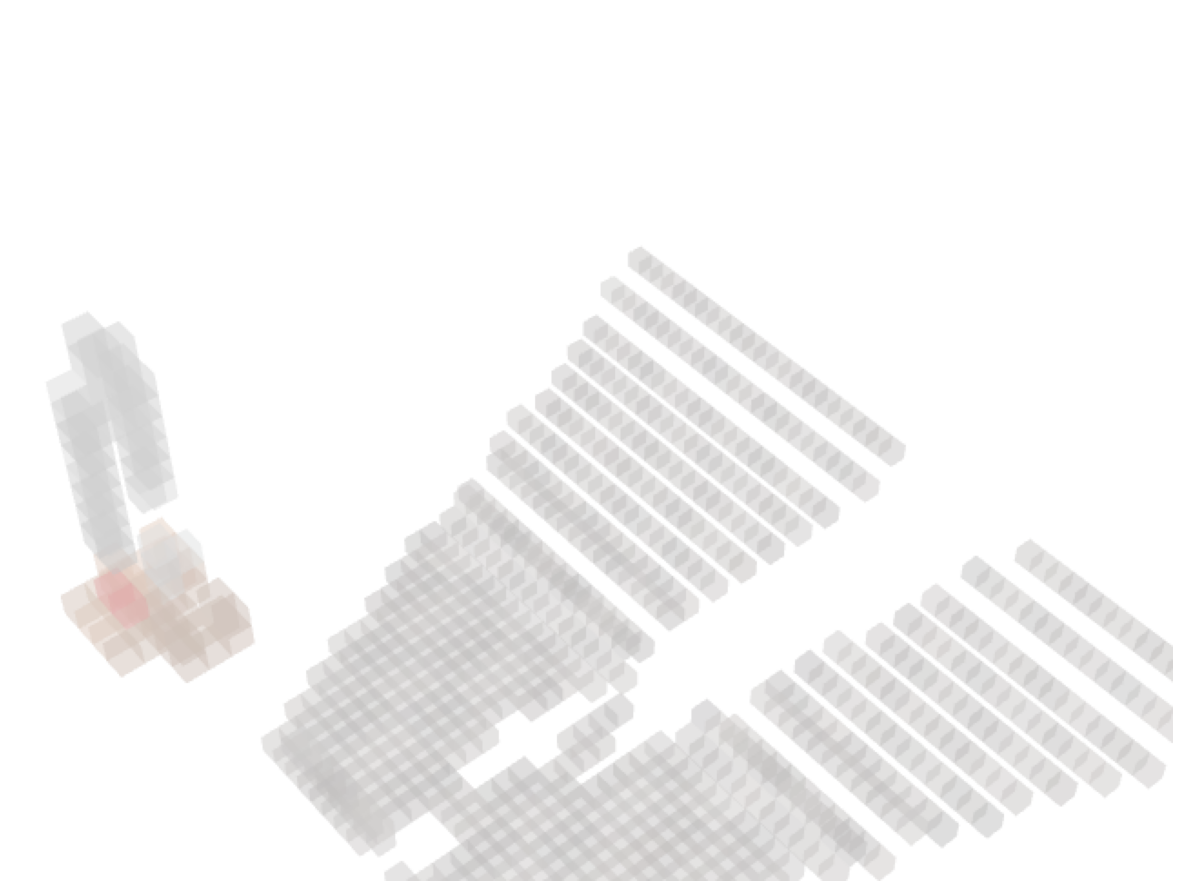

In [7]:
# visualize the original voxel grid 
voxel_grid = obs["voxel_grid"]
print(voxel_grid.shape)
print(obs.keys())
vis_voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach().cpu().numpy()
rotation_amount = 50
rendered_img = visualise_voxel(vis_voxel_grid[0],
                               None,
                               None,
                               voxel_size=0.01,
                               zoom_factor=2,
                               rotation_amount=np.deg2rad(rotation_amount))
fig = plt.figure(figsize=(15, 15))
plt.imshow(rendered_img)
plt.axis('off')


(-0.5, 639.5, 479.5, -0.5)

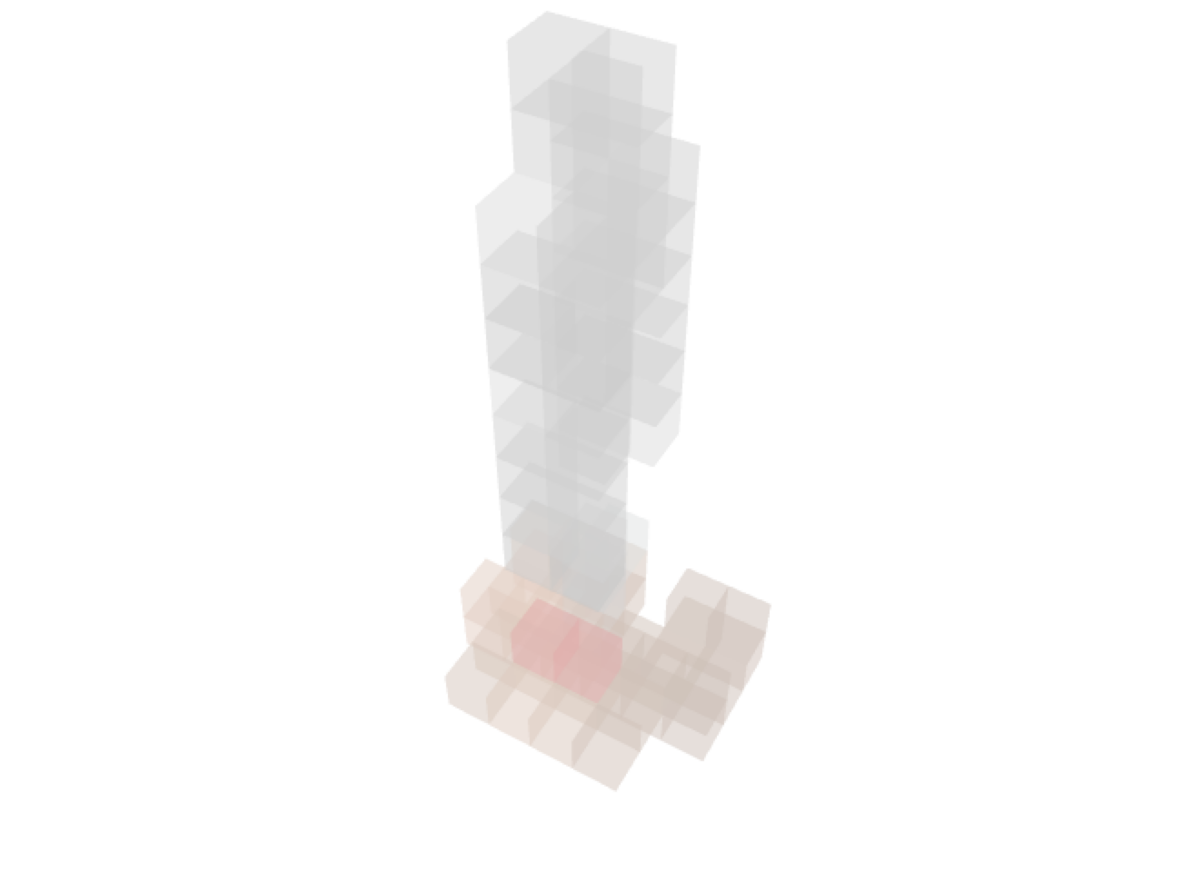

In [8]:
# visualize the filtered voxel grid (applicable only if segmentation=True)
flood_id = 17
floor_map = (vis_voxel_grid[:, 9, ...] == flood_id)
floor_map = torch.tensor(floor_map)
floor_map = floor_map.unsqueeze(1).repeat(1, 11, 1, 1, 1)
vis_voxel_grid[floor_map] = 0
rotation_amount = 30
rendered_img = visualise_voxel(vis_voxel_grid[0],
                               None,
                               None,
                               voxel_size=0.01,
                               zoom_factor=1.1,
                               rotation_amount=np.deg2rad(rotation_amount))

fig = plt.figure(figsize=(15, 15))
plt.imshow(rendered_img)
plt.axis('off')



# 2. Saving a video
Restart the kernel before running the below cell.

In [ ]:
import cv2
import numpy as np

def render_filtered_voxels(voxel_grid):
    flood_id = 17
    vis_voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach().cpu().numpy()
    floor_map = (vis_voxel_grid[:, 9, ...] == flood_id)
    floor_map = torch.tensor(floor_map)
    floor_map = floor_map.unsqueeze(1).repeat(1, 11, 1, 1, 1)
    vis_voxel_grid[floor_map] = 0
    rotation_amount = 30
    rendered_img = visualise_voxel(vis_voxel_grid[0],
                                None,
                                None,
                                voxel_size=0.01,
                                zoom_factor=1.1,
                                rotation_amount=np.deg2rad(rotation_amount))
    return rendered_img

def images_to_video(image_list, output_path, fps=30, is_color=True):
    """
    Converts a list of RGB images to a video and saves it to the specified path.

    Parameters:
    - image_list (list of numpy arrays): List of RGB images.
    - output_path (str): Path to save the output video.
    - fps (int): Frames per second for the output video.
    - is_color (bool): True if the images are in color (RGB), False if grayscale.

    Returns:
    - None
    """

    # Ensure there are images in the list
    if not image_list:
        raise ValueError("The image list is empty.")

    # Get the size of the images
    height, width = image_list[0].shape[:2]

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can also use other codecs, like 'XVID'
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height), is_color)

    # Write each image to the video
    for image in image_list:
        if is_color and len(image.shape) == 2:
            raise ValueError("Expected RGB images but received a grayscale image.")
        if not is_color and len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        video_writer.write(image)

    # Release the VideoWriter object
    video_writer.release()


In [ ]:
# Try stepping and saving a video
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode

env_id = "PickCube-v1" 
obs_mode = "voxel" 
obs_mode_config = {"coord_bounds": [-13, -10, -1, 1, 10, 1], "voxel_size": 200, 
                   "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                   "segmentation": True}
control_mode = "pd_joint_delta_pos"
reward_mode = "dense"
robot_uids = "panda"
# create an environment with our configs and then reset to a clean state
env = gym.make(env_id,
               num_envs=1,
               obs_mode=obs_mode,
               reward_mode=reward_mode,
               control_mode=control_mode,
               robot_uids=robot_uids,
               obs_mode_config=obs_mode_config,
               enable_shadow=True # this makes the default lighting cast shadows
               )

# step through the environment with random actions
obs, _ = env.reset()
imgs = []
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
    voxel_grid = obs["voxel_grid"]
    img = render_filtered_voxels(voxel_grid)
    imgs.append(img)
    # env.render_human() # will render with a window if possible
env.close()


# write a video showing voxel changes
import cv2
images_to_video(imgs, "./mstestres/0.mp4")

# display
from IPython.display import Video
Video("./mstestres/0.mp4", embed=True, width=640) # Watch our replay

OutOfMemoryError: CUDA out of memory. Tried to allocate 314.00 MiB. GPU 0 has a total capacity of 5.79 GiB of which 34.19 MiB is free. Including non-PyTorch memory, this process has 5.75 GiB memory in use. Of the allocated memory 4.95 GiB is allocated by PyTorch, and 578.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)